# Pattern Recognition 2022-23 1st Lab: Speech Recognition with Hidden Markov Models and Recurrent Neural Networks<br>

Ηλιόπουλος Γεώργιος: 03118815 <br>
Σερλής Αναστάσιος Εμανουήλ - 03118125<br>
<br>
Προπαρασκευή

## Imports

In [1]:
#!pip install librosa
#!pip install pytorch

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Libraries

In [3]:
import torch
import librosa
import pandas
import numpy as np
import os
import matplotlib.pyplot as plt
from word2number import w2n
import re
import IPython.display as ipd
import sounddevice as sd
import pandas as pd
from sklearn.decomposition import PCA

C:\Users\grgsl\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Step 2 - Data Parser

In [169]:
digits_dir = "./digits"
n_samples=133

def data_parser(dir):
    wavs = [None] * n_samples
    speakers = np.zeros(n_samples, dtype=int)
    digits = np.zeros(n_samples, dtype=int)

    for i, file in enumerate(os.listdir(dir)):
         fl=os.fsdecode(file) #read file name
         wavs[i], _ = librosa.load(os.path.join(dir, fl), sr=16000) #librosa load
         temp_list = re.split(r'(^[^\d]+)',fl.split('.')[0] )[1:] # split word and speaker
         digits[i] = w2n.word_to_num(temp_list[0]) #get digit 
         speakers[i] = int(temp_list[1]) #get speaker

    return wavs, speakers, digits

wavs,speakers,digits = data_parser(digits_dir)
for i in range(10): #print wav sample, speaker and digit for 10 first files
    print("wav_file: {}\t speaker = {}\t digit = {}\t samples = {}".format(i+1,speakers[i],digits[i],wavs[i][:3]))

print("We have {} wav files for {} digits from {} different speakers."\
      .format(len(wavs), np.unique(digits).shape[0], np.unique(speakers).shape[0]))
#check sound on speaker 1 and diff digits
sd.play(wavs[0], 16000) #speaker 1 - digit 8
sd.play(wavs[14],16000) #speaker 1 - digit 5

wav_file: 1	 speaker = 1	 digit = 8	 samples = [-0.0007019  -0.00088501 -0.00048828]
wav_file: 2	 speaker = 10	 digit = 8	 samples = [ 9.1552734e-05 -3.0517578e-05 -2.7465820e-04]
wav_file: 3	 speaker = 11	 digit = 8	 samples = [-0.0010376  -0.00109863 -0.00112915]
wav_file: 4	 speaker = 12	 digit = 8	 samples = [1.2207031e-04 9.1552734e-05 3.0517578e-05]
wav_file: 5	 speaker = 13	 digit = 8	 samples = [-0.0005188  -0.00045776 -0.00064087]
wav_file: 6	 speaker = 14	 digit = 8	 samples = [-0.00045776 -0.00018311  0.00024414]
wav_file: 7	 speaker = 15	 digit = 8	 samples = [-0.00021362 -0.00015259  0.        ]
wav_file: 8	 speaker = 2	 digit = 8	 samples = [ 1.5258789e-04  2.1362305e-04 -3.0517578e-05]
wav_file: 9	 speaker = 3	 digit = 8	 samples = [0.00012207 0.0005188  0.00021362]
wav_file: 10	 speaker = 4	 digit = 8	 samples = [-0.00036621 -0.00048828 -0.00045776]
We have 133 wav files for 9 digits from 15 different speakers.


In [168]:
np.unique(digits).shape[0]

9

## Step 3 - Extract MFCCs

In [5]:
sr=16000 #wanted parameters for mfcc
feats=13
win_length=0.025
step=0.01

mfccs=[]
delta=[]
delta2=[]

for i in range(n_samples): #compute mfccs, delta (1st and 2nd order)
    mfcc_temp = librosa.feature.mfcc(wavs[i], sr=sr, n_mfcc=feats, hop_length=int(win_length*sr), n_fft=int(step*sr))
    mfccs.append(mfcc_temp)
    delta.append(librosa.feature.delta(mfcc_temp))
    delta2.append(librosa.feature.delta(mfcc_temp, order=2))



C:\Users\grgsl\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [171]:
print("MFCCS  shape is {} with shape {}.".format(type(mfccs[0]),mfccs[0].shape))
print("delta  shape is {} with shape {}.".format(type(delta[0]),delta[0].shape))
print("delta2 shape is {} with shape {}.".format(type(delta2[0]),delta2[0].shape))

MFCCS  shape is <class 'numpy.ndarray'> with shape (13, 30).
delta  shape is <class 'numpy.ndarray'> with shape (13, 30).
delta2 shape is <class 'numpy.ndarray'> with shape (13, 30).


In [172]:
len(mfccs)

133

## Step 4 - Histograms of 1st and 2nd MFCCs

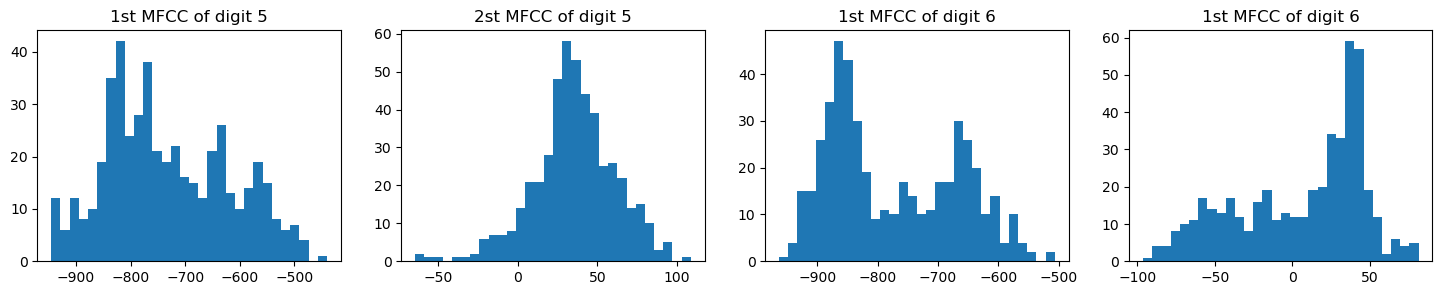

In [187]:
# AM1: 031 18 125 --> n1 = 5
# AM2: 031 18 815 --> n2 = 5 -> 6
n1=5
n2=6

# Extract 1st and 2nd mfcc of digit 5
mfcc1_n1 = [mfccs[i][0] for i in range(n_samples) if digits[i] == n1]
mfcc2_n1 = [mfccs[i][1] for i in range(n_samples) if digits[i] == n1]

# Extract 1st and 2nd mfcc of digit 6
mfcc1_n2 = [mfccs[i][0] for i in range(n_samples) if digits[i] == n2]
mfcc2_n2 = [mfccs[i][1] for i in range(n_samples) if digits[i] == n2]

#flattened lists
mfcc1_n1_fl=list(np.concatenate(mfcc1_n1).flat)
mfcc2_n1_fl=list(np.concatenate(mfcc2_n1).flat)
mfcc1_n2_fl=list(np.concatenate(mfcc1_n2).flat)
mfcc2_n2_fl=list(np.concatenate(mfcc2_n2).flat)


# Plot histograms
fig = plt.figure(figsize=(18,3))
ax1=fig.add_subplot(1, 4, 1)
plt.hist(mfcc1_n1_fl, bins=30)
ax1.title.set_text('1st MFCC of digit {}'.format(n1))
ax2=fig.add_subplot(1, 4, 2)
plt.hist(mfcc2_n1_fl, bins=30)
ax2.title.set_text('2st MFCC of digit {}'.format(n1))
ax3=fig.add_subplot(1, 4, 3)
plt.hist(mfcc1_n2_fl, bins=30)
ax3.title.set_text('1st MFCC of digit {}'.format(n2))
ax4=fig.add_subplot(1, 4, 4)
plt.hist(mfcc2_n2_fl, bins=30)
ax4.title.set_text('1st MFCC of digit {}'.format(n2))
plt.show()

In [8]:
#get 2 instances for each of the digits 5 and 6
speaker1=2
speaker2=14
index1_n1 = int(np.where((speakers == speaker1) & (digits == n1) )[0][0])
index2_n1 = int(np.where((speakers == speaker2) & (digits == n1) )[0][0])
index1_n2 = int(np.where((speakers == speaker1) & (digits == n2) )[0][0])
index2_n2 = int(np.where((speakers == speaker2) & (digits == n2) ) [0][0])

print('\033[1m' + "Samples selected for MFSC & MFCC correlation:" + '\033[0m')
print("Speaker={}\t digit={}\t index={}".format(speaker1,n1,index1_n1))
print("Speaker={}\t digit={}\t index={}".format(speaker1,n2,index1_n2))
print("Speaker={}\t digit={}\t index={}".format(speaker2,n1,index2_n1))
print("Speaker={}\t digit={}\t index={}".format(speaker2,n2,index2_n2))

#extract MFSCs for selected 4 samples
mfsc1_n1 = librosa.feature.melspectrogram(wavs[index1_n1], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc1_n2 = librosa.feature.melspectrogram(wavs[index1_n2], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc2_n1 = librosa.feature.melspectrogram(wavs[index2_n1], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)
mfsc2_n2 = librosa.feature.melspectrogram(wavs[index2_n2], sr=sr, hop_length=int(win_length*sr), n_fft=int(step*sr), n_mels=feats)


Samples selected for MFSC & MFCC correlation:
Speaker=2	 digit=5	 index=21
Speaker=2	 digit=6	 index=95
Speaker=14	 digit=5	 index=19
Speaker=14	 digit=6	 index=93


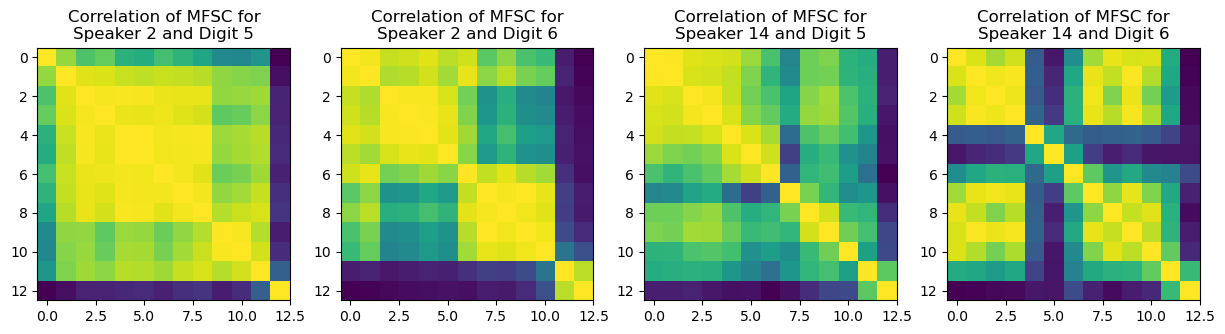

In [179]:
# plot correlation for MFSC for each instance
fig = plt.figure(figsize=(15,12))

#plt.title("HI\n")

ax1=fig.add_subplot(1, 4, 1)
ax1.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker1, n1))
plt.imshow((pd.DataFrame.from_records(mfsc1_n1.T)).corr())

ax3=fig.add_subplot(1, 4, 2)
ax3.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker1, n2))
plt.imshow((pd.DataFrame.from_records(mfsc1_n2.T)).corr())

ax5=fig.add_subplot(1, 4, 3)
ax5.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker2, n1))
plt.imshow((pd.DataFrame.from_records(mfsc2_n1.T)).corr())

ax7=fig.add_subplot(1, 4, 4)
ax7.title.set_text('Correlation of MFSC for\nSpeaker {} and Digit {}'.format(speaker2, n2))
plt.imshow((pd.DataFrame.from_records(mfsc2_n2.T)).corr())


plt.show()

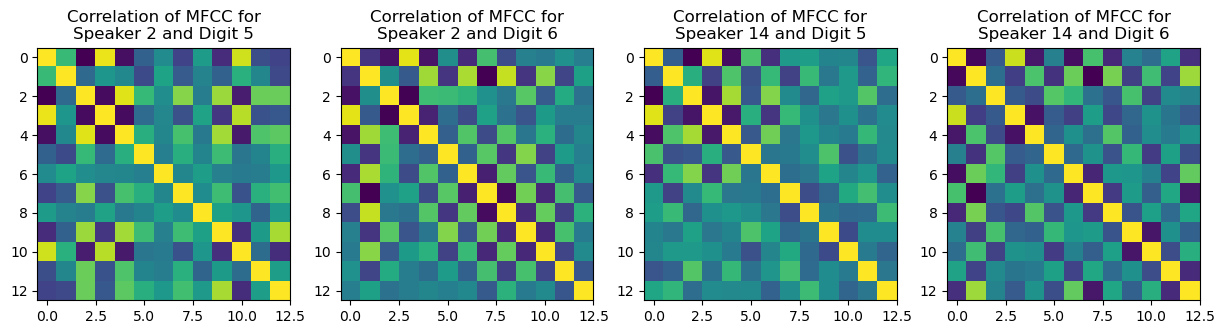

In [178]:
# plot correlation for MFCC for each instance
fig = plt.figure(figsize=(15,12))

ax1=fig.add_subplot(1, 4, 1)
ax1.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker1, n1))
plt.imshow((pd.DataFrame.from_records(mfccs[index1_n1].T)).corr())

ax2=fig.add_subplot(1, 4, 2)
ax2.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker1, n2))
plt.imshow((pd.DataFrame.from_records(mfccs[index1_n2].T)).corr())


ax3=fig.add_subplot(1, 4, 3)
ax3.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker2, n1))
plt.imshow((pd.DataFrame.from_records(mfccs[index2_n1].T)).corr())

ax4=fig.add_subplot(1, 4, 4)
ax4.title.set_text('Correlation of MFCC for\nSpeaker {} and Digit {}'.format(speaker2, n2))
plt.imshow((pd.DataFrame.from_records(mfccs[index2_n2].T)).corr())

plt.show()

## Step 5 - Feature Extraction

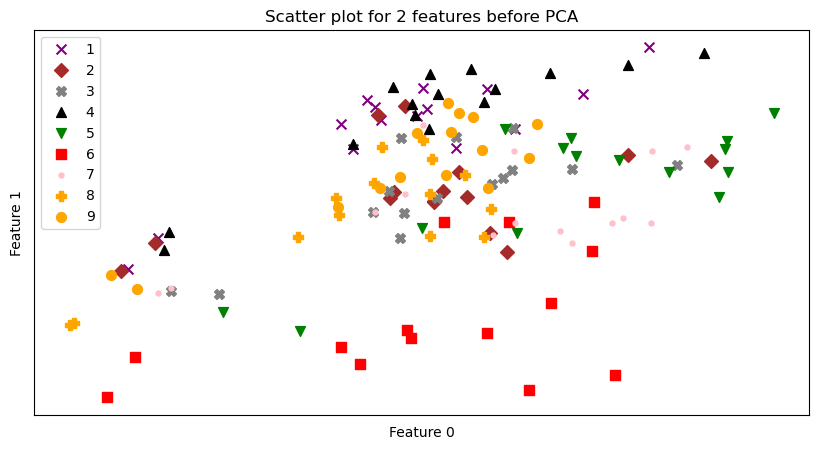

In [193]:
#get global feature extraction
# 133 rows which correspond to the total samples
# 6*13 columns which correspond to the mean values and variance for each one of the 13 different mfcc features

features = np.zeros((n_samples, 6*13))
for i in range(n_samples):
    features[i, :13] = np.mean(mfccs[i], axis=1)
    features[i, 13:26] = np.mean(delta[i], axis=1)
    features[i, 26:39] = np.mean(delta2[i], axis=1)
    features[i, 39:52] = np.std(mfccs[i], axis=1)
    features[i, 52:65] = np.std(delta[i], axis=1)
    features[i, 65:  ] = np.std(delta2[i], axis=1)

colors = ['orange', 'black', 'orange', 'pink', 'gray', 'green', 'purple', 'brown', 'red'] #set different colors
numbers=[i for i in range(1,10)] #set digit values
symbols = ['.', 'o', 'v', '^', 'x', 'D', "X", 's', 'P']


def scatter(feats, y, dims=2, PCA=1):
    if dims == 2: #in case of 2 feats
        #plt.rcParams['figure.figsize'] = [10, 5]
        fig, ax = plt.subplots()
        feat0 = feats[:, 0]
        feat1 = feats[:, 1]
        for i in range(9):
             ax.scatter(feat0[y == i+1], feat1[y == i+1], c=colors[i],
                    label=numbers[i], s=50, alpha=1,marker = symbols[i])
             ax.set_xlabel('Feature 0')
             ax.set_ylabel('Feature 1')
             if(PCA==0):
                 ax.title.set_text('Scatter plot for 2 features before PCA')
             if(PCA==1):
                 ax.title.set_text('Scatter plot for 2 features after PCA')
            
    if dims == 3: #in case of 3 feats
        plt.rcParams['figure.figsize'] = [7, 7]
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        feat0 = feats[:, 0]
        feat1 = feats[:, 1]
        feat2 = feats[:, 2]
        for i in range(9):
            ax.scatter(feat0[y == i+1], feat1[y == i+1], feat2[y == i+1], c=colors[i],
                    label=numbers[i], s=50, alpha=1,marker = symbols[i])
            ax.set_xlabel('Feature 0')
            ax.set_ylabel('Feature 1')
            ax.set_zlabel('Feature 2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

plt.rcParams['figure.figsize'] = [10, 5]    
np.random.shuffle(colors)
np.random.shuffle(symbols)
scatter(features,digits,2,PCA=0)

## Step 6 - PCA

In [190]:
#set 2d and 3d PCAs

PCA_2D= PCA(n_components=2)
PCA_3D= PCA(n_components=3)

#reduce to two and three dims via PCA
feats_pca2d = PCA_2D.fit_transform(features)
feats_pca3d = PCA_3D.fit_transform(features)

# find varinace ratios
print("Variance ratio after 2D PCA is:",(PCA_2D.explained_variance_ratio_[0])*100,"%","and",(PCA_2D.explained_variance_ratio_[1])*100,"%")
print("Variance ratio after 3D PCA is:",(PCA_3D.explained_variance_ratio_[1])*100,"%","and",(PCA_3D.explained_variance_ratio_[1])*100,"%","and",(PCA_3D.explained_variance_ratio_[2])*100,"%")

Variance ratio after 2D PCA is: 67.38224671969732 % and 11.80149020251835 %
Variance ratio after 3D PCA is: 11.80149020251835 % and 11.80149020251835 % and 7.443867527498668 %


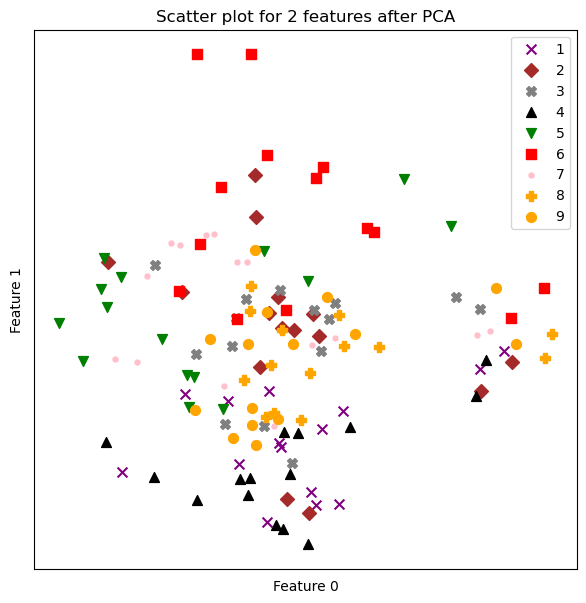

In [200]:
#scatter plot for 2d-pca
#np.random.shuffle(colors)
#np.random.shuffle(symbols)
plt.rcParams['figure.figsize'] = [7, 7] 
scatter(feats_pca2d,digits,2,PCA=1)

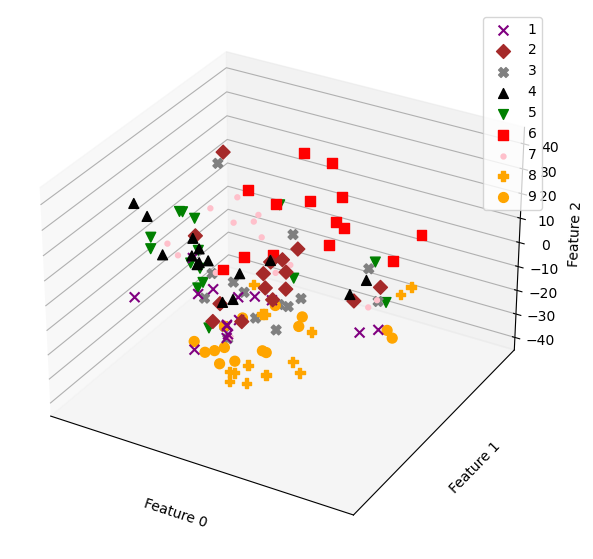

In [201]:
#scatter plot for 3d-pca
#np.random.shuffle(colors)
#np.random.shuffle(symbols)
scatter(feats_pca3d,digits,3,PCA=1)

In [211]:
print(PCA_2D.explained_variance_ratio_)
print(np.sum(PCA_2D.explained_variance_ratio_))
print(PCA_3D.explained_variance_ratio_)
print(np.sum(PCA_3D.explained_variance_ratio_))

[0.67382247 0.1180149 ]
0.7918373692221566
[0.67382247 0.1180149  0.07443868]
0.8662760444971433


In [215]:
type(PCA_2D) == type(pca_iD)

True

In [238]:
pcas = []
max_d = 15
var = []

for i in range(max_d):
    pca_iD = PCA(n_components = i)
    pca_iD.fit_transform(features)
    var.append(np.sum(pca_iD.explained_variance_ratio_)*100)

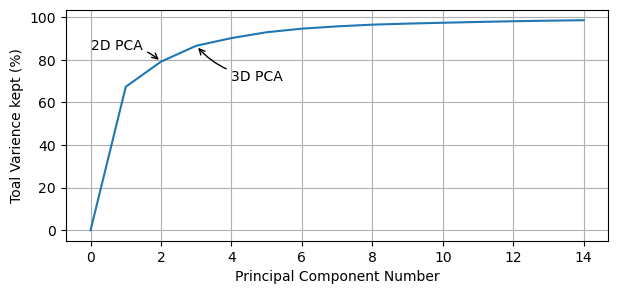

In [241]:
fig=plt.figure(figsize=(7,3))
plt.plot(range(max_d), var)
plt.ylabel("Toal Varience kept (%)")
plt.xlabel("Principal Component Number")
plt.annotate('2D PCA',xy=(2,79.18),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),xytext=(0,85))
plt.annotate('3D PCA',xy=(3,86.627),arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),xytext=(4,70))
plt.grid()

## Step 7 - Classification

In [15]:
# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
from scipy.stats import multivariate_normal as mn

In [101]:
#importing Custom Naive Bayes Classifier from 1st lab with a few changes
class CustomNBClassifier(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.classes = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        self.classes = np.unique(y)
        train_size, n_features = X.shape
        self.n_classes = len(self.classes)
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for count, value in enumerate(self.classes):
            idx_i = [i for i in range(train_size) if y[i] == value]
            X_i = np.take(X, idx_i, axis=0)
            self.X_mean_[count, :] = np.mean(X_i, axis=0, keepdims=True)
            self.X_var_[count, :] = np.var(X_i, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.zeros(self.n_classes)
        for i, value in enumerate(self.classes):
            self.prior[i] = np.count_nonzero(y == value) / train_size
        return self
        

    def predict(self, X):
        """
        Make predictions for X based on
        the highest posterior probability
        """

        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ 10**(-9))) * \
                      np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + 10**(-9)))) \
                      , axis=1)

        return np.argmax(like.T * self.prior, axis=1) + 1
    
    def score(self, X, y): #returns accuracy
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        count = 0
        y_pred = self.predict(X)
        for i in range(len(y)):
            if y[i] == y_pred[i]:
                count += 1
        acc = count / len(y)
        return acc

In [65]:
#splitting data in test and train sets
X_train, X_test, y_train, y_test = train_test_split(features, digits, test_size=0.3, random_state=42, stratify=y)

#normalizing data
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

In [140]:
def score_print(classifier):
    cl = classifier
    print('\033[1m' + cl.__class__.__name__ + '\033[0m')
    cl.fit(X_train, y_train)
    a = cl.score(X_test, y_test)
    print("Normalized Data: {},\taccuracy: {}".format("no", a))
    cl = classifier
    cl.fit(X_train_norm, y_train)
    a = cl.score(X_test_norm, y_test)
    print("Normalized Data: {},\taccuracy: {}".format("yes", a))
    print()

In [142]:
score_print(CustomNBClassifier())
score_print(GaussianNB())
score_print(KNeighborsClassifier(n_neighbors=3))
score_print(LogisticRegression())
score_print(SVC(kernel="linear", probability=True))

CustomNBClassifier
Normalized Data: no,	accuracy: 0.625
Normalized Data: yes,	accuracy: 0.575

GaussianNB
Normalized Data: no,	accuracy: 0.625
Normalized Data: yes,	accuracy: 0.575

KNeighborsClassifier
Normalized Data: no,	accuracy: 0.525
Normalized Data: yes,	accuracy: 0.525

LogisticRegression
Normalized Data: no,	accuracy: 0.725
Normalized Data: yes,	accuracy: 0.175

SVC
Normalized Data: no,	accuracy: 0.75
Normalized Data: yes,	accuracy: 0.175



C:\Users\grgsl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Step 8 - Pytorch

In [20]:
# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

In [147]:
#generating our data
f = 40
T = 1/f
step = 0.001
X = np.zeros((1500, 10))
y = np.zeros((1500, 10))

for i in range(len(X)):
    A = np.random.rand() #getting a random amplitude (0,1)
    start = np.random.rand() * (T) #getting a random starting point
    time = np.linspace(start, start+step*10, num=10)
    X[i] = A*np.sin(2*np.pi*f*time)
    y[i] =  A*np.cos(2*np.pi*f*time)

Text(0.5, 1.0, 'cosine no10')

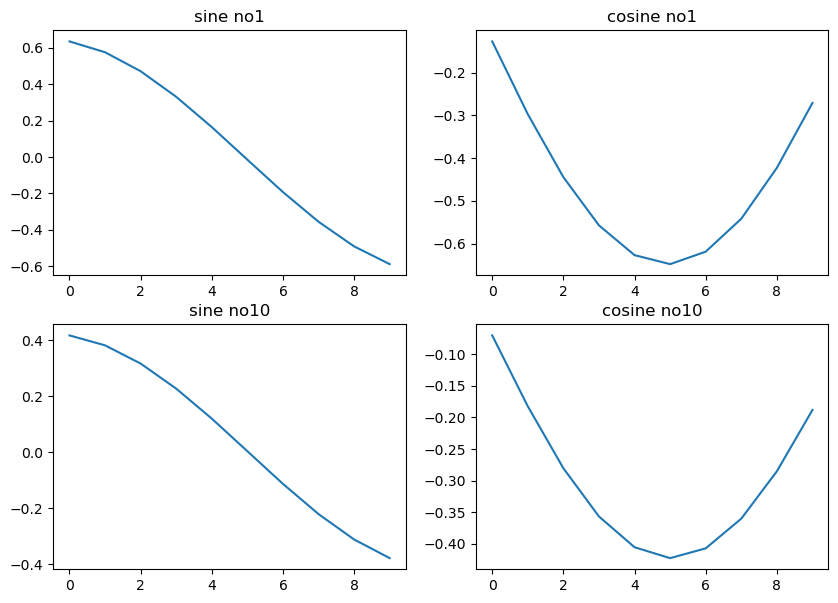

In [148]:
# plotting some of the data
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.plot(range(10), X[1])
plt.title("sine no1")
plt.subplot(2,2,2)
plt.plot(range(10), y[1])
plt.title("cosine no1")
plt.subplot(2,2,3)
plt.plot(range(10), X[10])
plt.title("sine no10")
plt.subplot(2,2,4)
plt.plot(range(10), y[10])
plt.title("cosine no10")

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [24]:
#Define an LSTM(?)
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTMCell(1, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [159]:
# model parameters
model = LSTMNet().double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [163]:
#Training
train_losses = []
test_losses = []

epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    if i%100 == 0:
        print("Epoch:\t{}".format(i), end='\t')
        print('Train loss', loss.item(),end='\t')
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, y_test)
        if i%100 == 0:
            print('Test loss:', loss.item())
            print()
        test_losses.append(loss.item())

Epoch:	0	Train loss 0.01631706608708755	Test loss: 0.016377029689173622

Epoch:	100	Train loss 0.016321465013186712	Test loss: 0.016379469525380445

Epoch:	200	Train loss 0.016316798978919092	Test loss: 0.016377650488004134

Epoch:	300	Train loss 0.016316522400299693	Test loss: 0.016377258124617995

Epoch:	400	Train loss 0.01631629102231933	Test loss: 0.016377136497648395

Epoch:	500	Train loss 0.01631608731510533	Test loss: 0.01637715471420526

Epoch:	600	Train loss 0.0163159035590607	Test loss: 0.01637724490766219

Epoch:	700	Train loss 0.016315734873704676	Test loss: 0.01637737742523084

Epoch:	800	Train loss 0.0163155777680948	Test loss: 0.016377539348596568

Epoch:	900	Train loss 0.016316070050862674	Test loss: 0.016396442626693163

Epoch:	1000	Train loss 0.016315623528551766	Test loss: 0.016378798881640923

Epoch:	1100	Train loss 0.016315462017765174	Test loss: 0.016378542688459622

Epoch:	1200	Train loss 0.01631531924489479	Test loss: 0.016378643506139424

Epoch:	1300	Train loss

## Step 9 - Pytorch

In [ ]:
from glob import glob
import librosa as l
import os
from sklearn.preprocessing import StandardScaler
from pomegranate import *
import itertools
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
def parser(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, '*.wav'))
    fnames = [f.split('/')[1].split('.')[0].split('_') for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = l.core.load(files[0], sr=None)

    def read_wav(f):
        global Fs
        wav, fs = l.core.load(f, sr=None)
        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [l.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
    # Print dataset info
    print('Total wavs: {}'.format(len(frames)))

    # Standardize data
    scaler = StandardScaler()
    scaler.fit(np.concatenate(frames))
    for i in range(len(frames)):
        frames[i] = scaler.transform(frames[i])

    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ['0', '1', '2', '3', '4']
    for idx, frame, label, spk in zip(ids, frames, y, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [ ]:
def parse_free_digits(directory):
    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split("/")[1].split(".")[0].split("_") for f in files]
    print((fnames[10]))
    print((fnames[10][0]))
    print((fnames[12]))
    print((fnames[12][0]))
    print((fnames[15]))
    print((fnames[15][0]))
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    #y = [(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)

        return wav

    # Read all wavs
    wavs = [read_wav(f) for f in files]

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers

def extract_features(wavs, n_mfcc=6, Fs=8000):
    # Extract MFCCs for all wavs
    window = 30 * Fs // 1000
    step = window // 2
    frames = [
        librosa.feature.mfcc(
            wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=n_mfcc
        ).T

        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames

def split_free_digits(frames, ids, speakers, labels):
    print("Splitting in train test split using the default dataset split")
    # Split to train-test
    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test

def parser(directory, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames, ids, speakers, y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

In [ ]:
data_dir = './recordings'
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(data_dir)

## Step 10 - Pytorch